## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

Goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv("ab_data.csv")

b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. The number of unique users in the dataset.

In [6]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [7]:
df[df.converted == 1].count() / df.nunique().user_id

user_id         0.121263
timestamp       0.121263
group           0.121263
landing_page    0.121263
converted       0.121263
dtype: float64

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
df.query("group == 'treatment' and landing_page != 'new_page'").user_id.count()

1965

In [9]:
df.query("landing_page == 'new_page' and group != 'treatment'").user_id.count() + df.query("landing_page != 'new_page' and group == 'treatment'").user_id.count() 

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [11]:
df2 = df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) == True]

In [12]:
df2.shape

(290585, 5)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a. How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2.is_copy = False
df2.drop_duplicates(subset="user_id", keep="last", inplace=True)

/Users/uyujin/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/uyujin/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [18]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` 
a. What is the probability of an individual converting regardless of the page they receive?

In [58]:
p_all = sum(df2.converted == 1) / df2.shape[0]
p_all

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [27]:
new_page = df2[df2['group'] == 'treatment']
old_page = df2[df2['group'] == 'control']


In [28]:
old_page_cr = sum(old_page.converted == 1) / old_page.user_id.count()
old_page_cr

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [29]:
new_page_cr = sum(new_page.converted == 1) / new_page.user_id.count()
new_page_cr

0.11880806551510564

d. What is the probability that an individual received the new page?

In [30]:
new_page.shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

I don't think there is sufficient evidence to conclude the new treat page leads to more conversion. 
According to the probability above, the conversion rate of the treatment group is slighty less than the control group and even less than the average converion rate of the entire dataset. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} >= p_{new} $$
$$H_1: p_{old} < p_{new} $$

$$H_0: p_{old} - p_{new} >= 0  $$
$$H_1: p_{old} - p_{new} < 0 $$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [60]:
# p_new = sum(new_page['converted']) / new_page.shape[0]
p_new = p_all
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [61]:
# p_old = sum(old_page['converted']) / old_page.shape[0]
p_old = p_all
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [36]:
n_new = new_page.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [37]:
n_old = old_page.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [62]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [63]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [64]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.0011266766857708083

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [65]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

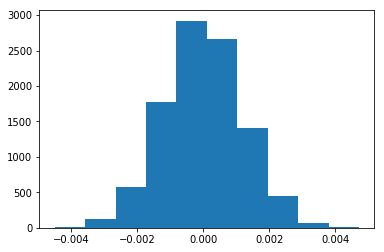

In [67]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [69]:
obs_diff = new_page_cr - old_page_cr
(p_diffs > obs_diff).mean()

0.9077

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

--> P-value is 0.9077, which indicates weak evidence against the null hypothesis so we fail to reject the null hypothesis in this case. 
There is no differecnce in conversion rate between the new and old pages. 



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [72]:
import statsmodels.api as sm

convert_old = sum(old_page['converted'])
convert_new = sum(new_page['converted'])
n_old = old_page.shape[0]
n_new = new_page.shape[0]


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [104]:
zstat, pval = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')
zstat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

zstat -1.3 means 1.3 standard deviation away from the mean and it's negatvie which means it's far below the mean. p-value is 0.90 which is same as the result we got from the section above

<a id='regression'></a>
### Part III - A regression approach

`1.` 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [89]:
df2['intercept'] = 1

In [91]:
df2[['willbedropped', 'ab_page']] = pd.get_dummies(df2['group'])

In [97]:
df2.drop('willbedropped', axis=1, inplace=True)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [99]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [100]:
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [101]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:36:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

-> The pvalue is different from the result of z-test because this model runs on the assumtion that alternative hypothesis is two-tailed comparing old page and new page.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

-> The landing page itself is not indicating strong relationship with the conversion rate, therefore it will be benefiecial to see how other factors influencing the converts too. 

Adding additional terms will require investigation on interaction between variables and make the model harder to interpret 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [106]:
df_country = pd.read_csv("countries.csv")
df2 = pd.merge(df2, df_country, on=['user_id'])
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [158]:
df2 = df2.join(pd.get_dummies(df2['country']))

ValueError: columns overlap but no suffix specified: Index(['CA', 'UK', 'US'], dtype='object')

In [161]:
lm_country = sm.OLS(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])

In [162]:
result_country = lm_country.fit()

In [163]:
result_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.178
Time:                        21:00:59   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1203      0.001    128.267      0.000       0.118       0.122
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
CA            -0.0042      0.003     -1.514      0.130      -0.010       0.001
UK             0.0010      0.001      0.744      0.457      -0.002       0.004
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         5.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Country is not satistically significant. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [150]:
df2["ca_page"] = df2["ab_page"]*df2["CA"]
df2["uk_page"] = df2["ab_page"]*df2["UK"]


In [151]:
lm_all = sm.OLS(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK', 'ca_page', 'uk_page']])

In [145]:
result_all = lm_all.fit()

In [146]:
result_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.197
Time:                        20:15:44   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1206      0.001    118.563      0.000       0.119       0.123
ab_page       -0.0022      0.001     -1.505      0.132      -0.005       0.001
CA            -0.0018      0.004     -0.467      0.641      -0.010       0.006
UK            -0.0006      0.002     -0.307      0.759      -0.004       0.003
ca_page       -0.0047      0.006     -0.845      0.398      -0.016       0.006
uk_page        0.0033      0.003      1.180      0.238      -0.002       0.009
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

None of the variable indicates strong evidence to reject null hypothesis. However, uk_page coef has positive value when UK variable alone has negative coefficient which might indicate the possiblity of high conversion rate from people in UK landing in new_page. 